# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [4]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import matplotlib.pyplot as plt
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import time


# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [5]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1
1,1392518336,0
2,361208576,1
3,1535215357,1
4,4396196375,1


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

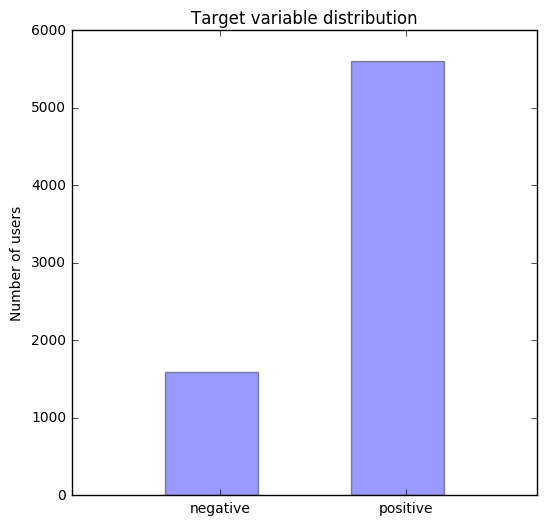

In [6]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [7]:
with open("consumer_key_secret.txt", 'r') as f:
    CONSUMER_SECRET = f.readline()

with open("access_token.txt", 'r') as f:
    ACCESS_TOKEN_KEY = f.readline()

with open("access_token_secret.txt", 'r') as f:
    ACCESS_TOKEN_SECRET = f.readline()

CONSUMER_KEY = "qHMnHG3j0c6KF97IOMIf3eHW8"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)


Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [8]:
GEO_USER_NAME = "lapsya"

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    from external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    # your code here
    parameters = {'q' : location, 'maxRows' : 1, 'username' : GEO_USER_NAME}
    r = requests.get('http://api.geonames.org/searchJSON?', params=parameters)
    
    if r.json()['totalResultsCount']:
        geoname = r.json()['geonames'][0]
        try:
            return (float(geoname['lat']), float(geoname['lng']), geoname['countryName'])
        except:
            print geoname
    return (0, 0, u'Gabon')
    

#get_coordinates_by_location('San Francisco, CA')

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [9]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

#original = sys.exc_info
#def f():
#    res = original()
#    print res
#    print res[1].args[0]
#    return res
#sys.exc_info = f
    
def get_user_records(df):
    # your code here
#    sys.exc_info = lambda: (None, ValueError([]), None)
    users = []
    users_100 = []
    i = 0
    for record in df.values:
        if int(record[0]) in processed_users:
            continue
        users_100.append(int(record[0]))
        i += 1
        if 100 == i:
            users += api.UsersLookup(user_id=users_100)
            i = 0
            users_100[:] = []
#    users = api.UsersLookup(user_id=[int(record[0]) for record in df.values])
    print users
#    users = api.UsersLookup(user_id=[593867346, 192217140])
#    print users
#    for df_record in df.values:
#        try:
#            user = api.GetUser(user_id=int(df_record[0]))
#        except:
#            print int(df_record[0])
#            print df_record
#            #time.sleep(60 * 15)
#            user = api.GetUser(user_id=int(df_record[0]))
#        user_rec = twitter_user_to_dataframe_record(user)
        # also write user as json line in temporary file
    user_recs = []
    for user in users:
        user_rec = twitter_user_to_dataframe_record(user)
        f.write(json.dumps(user_rec))
        user_recs.append(user_rec)
    return user_recs

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

#api.GetUser(user_id='202388889').screen_name

[User(ID=202388889, ScreenName=mustangkim11), User(ID=1392518336, ScreenName=TomboyTarts), User(ID=361208576, ScreenName=BigA85GL), User(ID=1535215357, ScreenName=laurynjiles), User(ID=4396196375, ScreenName=EdifyToUplift), User(ID=17938477, ScreenName=SkellyScribbles), User(ID=174004739, ScreenName=_MightyMarc_), User(ID=53783678, ScreenName=ladyattis), User(ID=257662370, ScreenName=NickWatchesMCU), User(ID=4795355113, ScreenName=KryptonsWizard), User(ID=1633971270, ScreenName=PikeFishing16), User(ID=2803810119, ScreenName=Vanguard90), User(ID=2244770588, ScreenName=EssenceCartoon), User(ID=102071251, ScreenName=Kersus), User(ID=3358825450, ScreenName=1991bucky), User(ID=555940842, ScreenName=eIectroheart), User(ID=2469354073, ScreenName=NicheMagazineUK), User(ID=360464656, ScreenName=Laneperson13), User(ID=77243076, ScreenName=RoneloLadiao), User(ID=1731752761, ScreenName=keegykuehne), User(ID=2330149164, ScreenName=sadglitterzzz), User(ID=2830586398, ScreenName=BasicsSuperhero), Use

In [10]:
print len(user_records)
print len(processed_users)
df_records.shape

11205
0


(11205, 15)

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

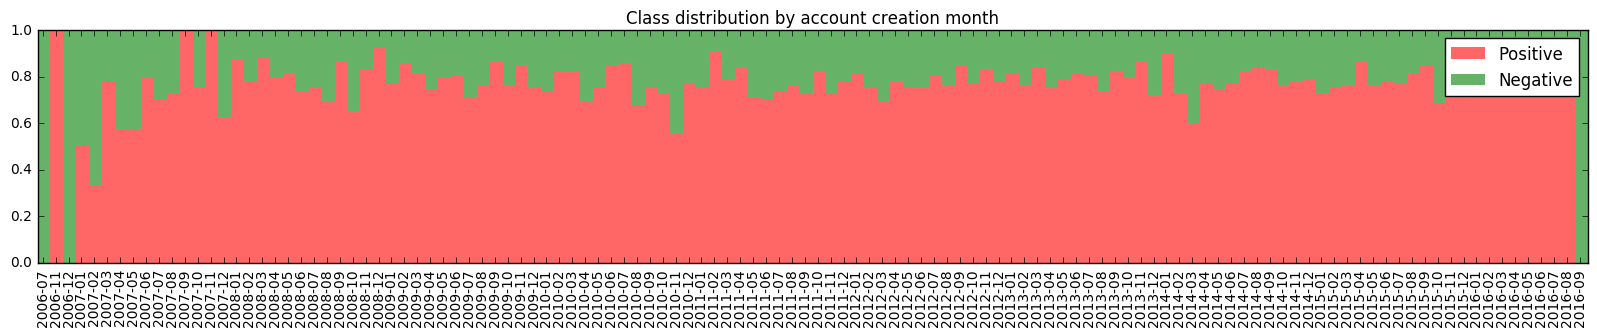

In [11]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    # 'cls' field
    i = 0
    for group in grouped:
        if group[0] != "NA":
            dts.append(group[0])
            pos_sum = 0
            neg_sum = 0
            for u in group[1]['cls']:
                if not isnan(u):
                    if u != 0:
                        pos_sum += 1
                    else:
                        neg_sum += 1
            count_pos[i] = pos_sum
            count_neg[i] = neg_sum
            i += 1
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)

pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()


Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


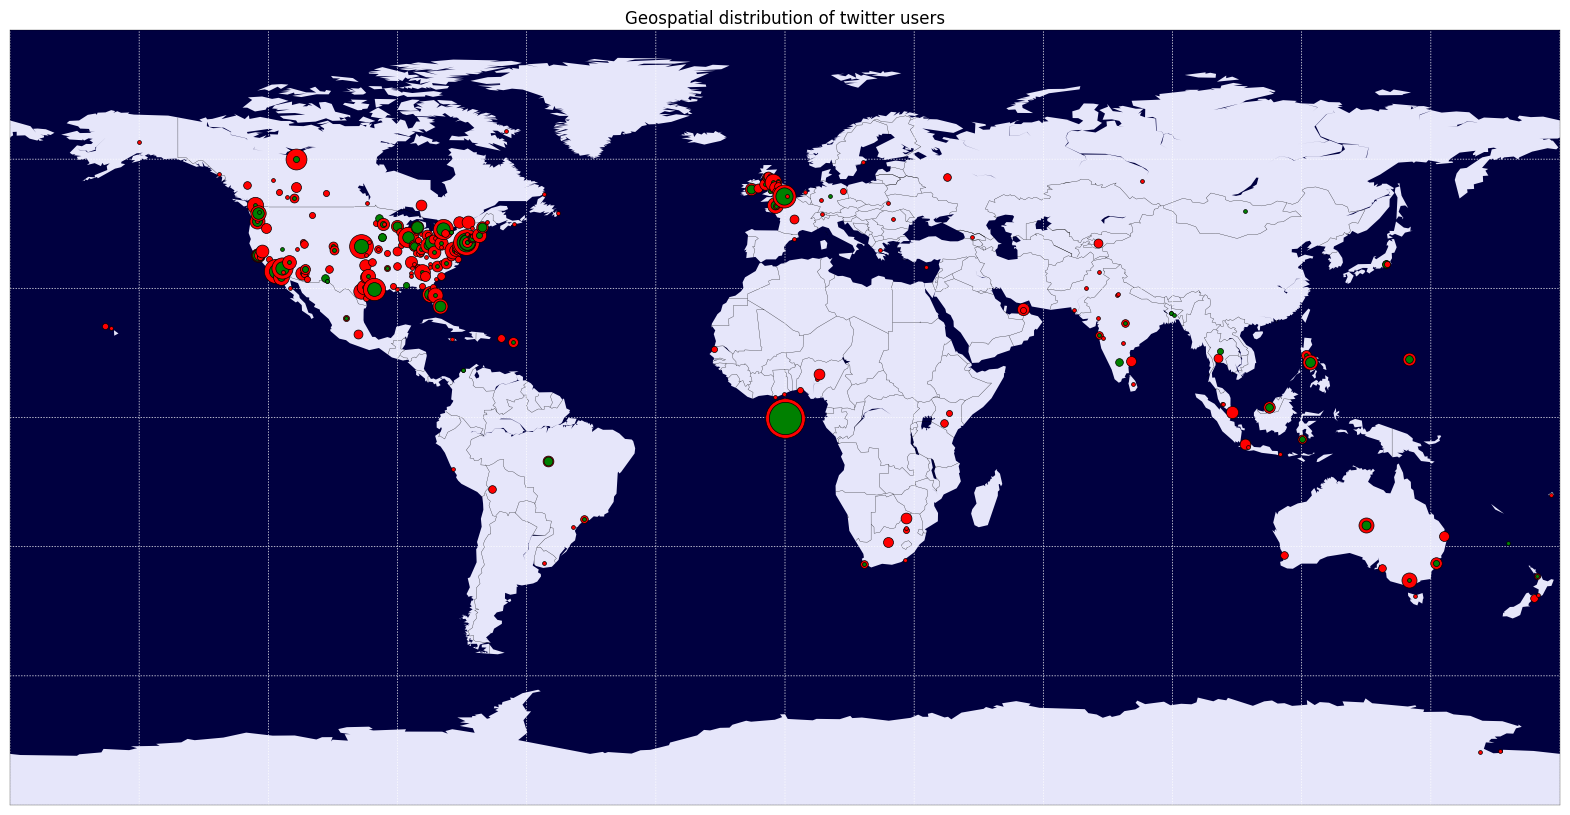

In [12]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    # your code here
    grouped = df_full.groupby(['lon', 'lat'])
    marker_base_size = 4
    for group in grouped:
        pos_size = 0
        neg_size = 0
        for category in group[1]['cls']:
            if not isnan(category):
                if category != 0:
                    pos_size += 1
                else:
                    neg_size += 1
        x, y = m(group[0][0], group[0][1])
        mylog = lambda z: log(z) if z > 0 else 0
        if pos_size > neg_size:
            m.plot(x, y, 'ro', markersize = marker_base_size * mylog(pos_size))
            m.plot(x, y, 'go', markersize = marker_base_size * mylog(neg_size))
        else:
            m.plot(x, y, 'ro', markersize = marker_base_size * mylog(pos_size))
            m.plot(x, y, 'go', markersize = marker_base_size * mylog(neg_size))
    return df_full

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:

* **все положительные и отрицательные пользователи одного города объединяются в две соответствующие точки, размеры маркеров которых зависят от числа пользователей в каждой из этих групп по функции `marker_base_size * ln(N)`, где `N` - число пользователей в группе**


#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [13]:
sample_number = 500
users_with_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_with_pos_class = df_full[df_full["cls"]==1].sample(sample_number)



def descriptive_stat_and_hist(users_with_neg_class, users_with_pos_class):
    #Calculate min max and median. Plot histogram
    #Your code here
    stats_pos = users_with_pos_class['followers_count'].describe()
    print 'Positive users:'
    print 'min: ' + str(int(stats_pos.values[3]))
    print 'max: ' + str(int(stats_pos.values[7]))
    print 'mean: ' + str(stats_pos.values[1])
    print 'median: ' + str(stats_pos.values[5])
    stats_neg = users_with_neg_class['followers_count'].describe()
    print '\nNegative users:'
    print 'min: ' + str(int(stats_neg.values[3]))
    print 'max: ' + str(int(stats_neg.values[7]))
    print 'mean: ' + str(stats_neg.values[1])
    print 'median: ' + str(stats_neg.values[5])
    

descriptive_stat_and_hist(users_with_neg_class, users_with_pos_class)

Positive users:
min: 1
max: 238728
mean: 2218.49176955
median: 358.0

Negative users:
min: 0
max: 138306
mean: 1929.4214876
median: 349.5



Смотрим на полученный data frame и сохраняем его в .csv файл.

In [14]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1053,1979,9507,21562,26
1,1392518336,0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1221,852,19504,7247,116
2,361208576,1,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,629,578,7897,1137,30
3,1535215357,1,Lauryn 🎃,laurynjiles,"xoxo, gossip girl.",False,#BLM,0.00000,0.00000,Gabon,2013-06,2375,2431,188134,89979,69
4,4396196375,1,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awareness...,False,God is my refuge,0.00000,0.00000,Gabon,2015-12,1253,997,39465,28592,81
